In [1]:
import numpy as np
import pandas as pd
import os,re
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class function_module :
    def __init__(self,summary_dataframe,sheet_list,protein_network) :
        self.summary : pd.io.excel._base.ExcelFile = summary_dataframe # type: ignore
        self.condition : list = sheet_list
        self.check_sheet_name()
        self.protein_network : str = protein_network
        
    def check_sheet_name(self) :
        for c in self.condition :
            if c not in self.summary.sheet_names :
                raise ValueError("Sheet name : %s not exist in given excel file" % c) 
    
    def functional_module_goinfo(self) :
        go_info = dict()
        for condition in self.condition :
            go_info[condition] = {}
            df = self.summary.parse(condition)
            df.index = df['GOID']
            for go in df.index :
                go_info[condition][go] = (df.loc[go,'Description'],df.loc[go,'#Nodes'])
        return go_info
    
    def edge2node(self,edge_context) :
        '''
        edge_list : str, like 'ENSG00000115415 ENSG00000138496_ENSG00000115415 ENSG00000168961_ENSG00000115415, underline as seperator
        '''
        edge_l = edge_context.split('_')
        node_l = set(list(map(lambda x : x.split(' ')[0],edge_l)) + list(map(lambda x : x.split(' ')[1],edge_l)))
        return list(node_l)
    
    def extract_expression_profile_of_module(self,summary_table,go_id,expression_profile):
        # expression_profile , row is gene (ensID) column is sample
        e = summary_table.loc[go_id,'Edges']
        gene_list = self.edge2node(e)
        return expression_profile.loc[set(gene_list).intersection(expression_profile.index),:]   


In [44]:
def vote_distribution(module,vote_result,prefix,output_path) :
    for condition in module.condition :
        df = module.summary.parse(condition)
        df.index = df['GOID']
        vote_df = pd.DataFrame()
        for go in df.index :
            gene_list = df.loc[go,'Nodes'].split('_')
            vote = vote_result.loc[gene_list,'Vote']
            result = pd.DataFrame({'Gene' : gene_list,'GO' : [go] * len(gene_list),'Vote' : vote})
            vote_df = pd.concat([vote_df,result])
        vote_df.to_csv(output_path + '%s_funModu_vote_result_%s.txt' % (prefix,condition),sep='\t')

def plot_vote_distribution(vote_result,module_df,prefix,output_path,output_format='pdf') :
    """
    Functional module vote distribution boxplot.
    Args:
        vote_result (pd.DataFrame): The vote number result, index is gene name, the Vote column is vote number of each gene.
        module_df (pd.DataFrame): The functional module summary.
        prefix (str): The prefix of boxplot.
        output_path (str): The output path of boxplot.
    """    
    go_info = {}
    vote_df = pd.DataFrame()
    module_df.index = module_df['GOID']
    vote_median = []
    for go in module_df.index :
        go_info[go] = (module_df.loc[go,'Description'],module_df.loc[go,'#Nodes'])
        gene_list = module_df.loc[go,'Nodes'].split('_')
        vote = vote_result.loc[gene_list,'Vote']
        vote_median.append(np.median(vote))
        result = pd.DataFrame({'Gene' : gene_list,'GO' : [go] * len(gene_list),'Vote' : vote})
        vote_df = pd.concat([vote_df,result])
    vote_median_df = pd.DataFrame({'Vote_median' : vote_median},index=module_df.index)
    go_order= vote_median_df.sort_values(by='Vote_median',ascending=False).index
        
    plt.figure(figsize=(8,7))
    ax = sns.boxplot(data=vote_df,x='Vote',y='GO',order=go_order,palette='Set3')
    label = [x.get_text() for x in ax.get_yticklabels()]
    description = [go_info[x][0] for x in label]
    ax.set_yticklabels(description)
    plt.savefig(output_path + "%s_funModu_vote_result.%s" % (prefix,output_format),dpi = 300,bbox_inches='tight')


In [46]:
repo_dir = '/home/bruce1996/repo/LIHC_anomaly_detection/'
ppi = 'GRN'
sheet_name = 'hbv_only_35'

module_df = pd.read_excel(repo_dir + "data/Functional-module-information/Summary_table_of_%s_FunModu.xlsx" % ppi,sheet_name=sheet_name)
exp_m = pd.read_csv(repo_dir + "data/Ensemble-learning-training-data/lihc_coding_gene_std_by_gene_%s_with_synthetic.txt" % 'hbv_only',sep='\t',index_col=0)
vote_result = pd.DataFrame({'Vote' : np.load(repo_dir + "data/Ensemble-leanring-result/with_synthetic/hbv_only_std_by_gene/hbv_only_std_by_gene_vote_np_ratio_35.npy")},index = exp_m.index)

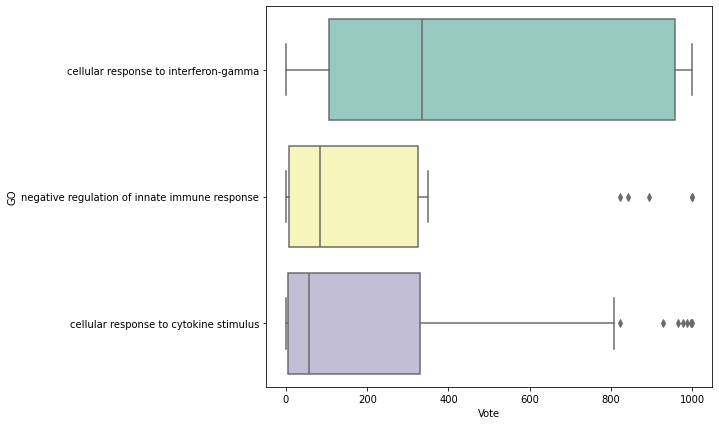

In [47]:
fig_output_path = repo_dir + 'result/functional_module_vote_distribution_boxplot/'
plot_vote_distribution(vote_result=vote_result,module_df=module_df,prefix='%s_%s' % (ppi,sheet_name),output_path=fig_output_path)